In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet import preprocess_input
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import recall_score,precision_score,f1_score,confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_datagen = ImageDataGenerator(
    validation_split=0.1,  # 10% of the data will be used for validation
    preprocessing_function=preprocess_input,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,  # New
    zoom_range=0.2,   # New
    brightness_range=[0.8, 1.2],  # New
    horizontal_flip=True,
    fill_mode='nearest'# it's IMPORTANT
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/train_data",
    shuffle = True,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    # Use the training subset
)

validation_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/train_data",
    shuffle = False,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'  # Use the validation subset
)

Found 8994 images belonging to 10 classes.
Found 996 images belonging to 10 classes.


In [5]:
model=keras.applications.EfficientNetB7(input_shape=(224,224,3),classes=10, weights="imagenet", include_top=False, pooling='avg')
for layer in model.layers:
    layer_name=layer.name.lower()
    if 'block'in layer_name and 'project_conv' in layer_name:
      layer.kernel_regularizer=l2(1e-3)
    else:
      layer.trainable = False
flatten = keras.layers.Flatten()(model.output)
xx=keras.layers.Dense(units=704, activation='relu',kernel_regularizer=l2(1e-3))(flatten)
x = keras.layers.Dense(units=10, activation='softmax',kernel_regularizer=l2(1e-3))(xx)
model_efnet = keras.models.Model(model.input, x)
model_efnet.summary()

258076736/258076736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)   

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.362114 to fit



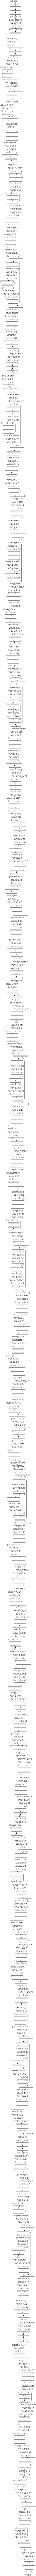

In [6]:
keras.utils.plot_model(model_efnet, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
model_efnet.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1e-3),
              metrics='accuracy')

In [8]:
lr_pl=ReduceLROnPlateau(monitor="val_accuracy",patience=3,min_delta=0.01,factor=0.05)
train_efnet=model_efnet.fit(train_generator,validation_data=validation_generator,epochs=12,callbacks=[lr_pl])

Epoch 1/12
563/563 [==============================] - 2374s 4s/step - loss: 2.4552 - accuracy: 0.3773 - val_loss: 1.8503 - val_accuracy: 0.4267 - lr: 0.0010
Epoch 2/12
563/563 [==============================] - 346s 613ms/step - loss: 1.6850 - accuracy: 0.4924 - val_loss: 1.7616 - val_accuracy: 0.4448 - lr: 0.0010
Epoch 3/12
563/563 [==============================] - 346s 615ms/step - loss: 1.4651 - accuracy: 0.5443 - val_loss: 1.5263 - val_accuracy: 0.5301 - lr: 0.0010
Epoch 4/12
563/563 [==============================] - 347s 617ms/step - loss: 1.2894 - accuracy: 0.6014 - val_loss: 1.5185 - val_accuracy: 0.5110 - lr: 0.0010
Epoch 5/12
563/563 [==============================] - 368s 653ms/step - loss: 1.1554 - accuracy: 0.6499 - val_loss: 1.4970 - val_accuracy: 0.5532 - lr: 0.0010
Epoch 6/12
563/563 [==============================] - 348s 617ms/step - loss: 1.0440 - accuracy: 0.6795 - val_loss: 1.4370 - val_accuracy: 0.5532 - lr: 0.0010
Epoch 7/12
563/563 [============================

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

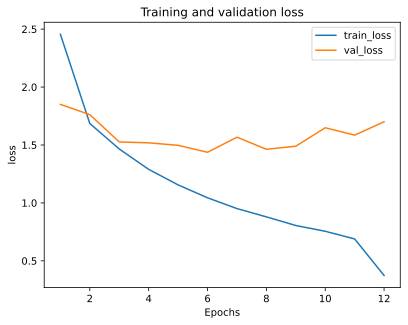

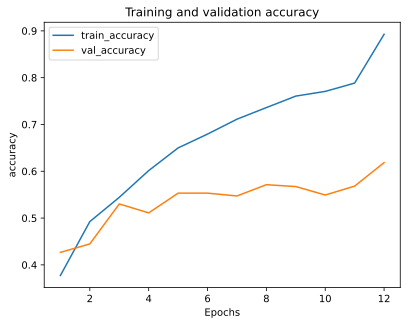

In [10]:
plot_metric(train_efnet , 'loss')
plot_metric(train_efnet , 'accuracy')

In [11]:
model_json=model_efnet.to_json()
with open("/content/drive/MyDrive/efnetb7_improvev2.json",'w') as json_file:
  json_file.write(model_json)

model_efnet.save_weights("/content/drive/MyDrive/efnetb7_improvev2.h5")
print(":))))))))))")

:))))))))))


In [12]:
train_efnet.history['loss']

[2.4551889896392822,
 1.6850417852401733,
 1.4651061296463013,
 1.289434552192688,
 1.1553696393966675,
 1.0439932346343994,
 0.9510016441345215,
 0.8792855143547058,
 0.8048489689826965,
 0.7550949454307556,
 0.6886729001998901,
 0.3733974099159241]

In [13]:
train_efnet.history['accuracy']

[0.3772515058517456,
 0.4924393892288208,
 0.5442517399787903,
 0.6014009118080139,
 0.649877667427063,
 0.6794529557228088,
 0.711251974105835,
 0.7360462546348572,
 0.7606182098388672,
 0.7706248760223389,
 0.788414478302002,
 0.8925950527191162]

In [14]:
train_efnet.history['val_accuracy']

[0.42670682072639465,
 0.4447791278362274,
 0.5301204919815063,
 0.5110442042350769,
 0.5532128810882568,
 0.5532128810882568,
 0.5471887588500977,
 0.5712851285934448,
 0.5672690868377686,
 0.5491967797279358,
 0.5682730674743652,
 0.6184738874435425]

In [15]:
train_efnet.history['val_loss']

[1.8503113985061646,
 1.7615784406661987,
 1.5263184309005737,
 1.5184907913208008,
 1.4970098733901978,
 1.4369529485702515,
 1.5672982931137085,
 1.4629406929016113,
 1.489384412765503,
 1.6485896110534668,
 1.5848051309585571,
 1.70037043094635]